In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import imageio
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams['figure.dpi'] = 150
import gc

<font size=7><b>CPSC471 Project: EDA for Chinese Traffic Sign Recognition Dataset</b></font>

**Ruomu (Felix) Zou**

The Chinese Traffic Sign Recognition Dataset (https://nlpr.ia.ac.cn/pal/trafficdata/recognition.html) is a dataset collected by the Chinese National Laboratory for Pattern Recognition (https://nlpr.ia.ac.cn/cn/index.html) and supported by the National Nature Science Foundation of China (https://www.nsfc.gov.cn/) with Grant 61271306. It contains zoomed-in images (often blurry) of 58 categories of common traffic signs in China ranging from speed limit signs to school-area-ahead signs.

# Load raw data files and first look:

We will begin by loading in the raw data files from the TSRD website above.

In [2]:
# folder location
data_folder = "../Data/"

# load in raw label files
labels_train = pd.read_csv(data_folder+"Labels_Train.txt", sep=";",
                           usecols=[0,1,2,3,4,5,6,7],
                           names=["ImageFile", "Width", "Height", "x1", "y1", "x2", "y2", "Category"])
labels_test = pd.read_csv(data_folder+"Labels_Test.txt", sep=";",
                          usecols=[0,1,2,3,4,5,6,7],
                          names=["ImageFile", "Width", "Height", "x1", "y1", "x2", "y2", "Category"])

# combine into one dataframe for easy analysis
labels_train["IsTest"] = False
labels_test["IsTest"] = True
labels_all = pd.concat([labels_train,labels_test])

The label files come with the following information:
* `ImageFile`: The file name of the image in question.
* `Width`: The width of the image.
* `Height`: The height of the image.
* `x1`/`y1`/`x2`/`y2`: Coordinates in the image where the sign itself is located.
* `Category`: A number representing the category index. There are no label names available anywhere online, so I had to look through all images and write label names for each of the categories (total 58), see below.

What do they look like?

In [3]:
labels_train

ImageFile  Width  Height  x1  y1   x2   y2  Category  IsTest
0       000_0001.png    134     128  19   7  120  117         0   False
1       000_0002.png    165     151  23  12  149  138         0   False
2       000_0003.png    128     122  22  14  116  105         0   False
3       000_0010.png     80      73  14   8   67   63         0   False
4       000_0011.png    186     174  36  15  155  157         0   False
...              ...    ...     ...  ..  ..  ...  ...       ...     ...
4165  056_1_0050.png    106     107  15  23   89   87        56   False
4166  056_1_0051.png    148     147  20  33  123  122        56   False
4167  056_1_0052.png    218     182  32  26  185  161        56   False
4168  056_1_0053.png    100     101  12  18   88   85        56   False
4169  056_1_0054.png    119     110  11  14  103   95        56   False

[4170 rows x 9 columns]

In [4]:
labels_test

ImageFile  Width  Height  x1  y1   x2   y2  Category  IsTest
0         000_0001_j.png     50      47  14   9   35   35         0    True
1         000_0002_j.png     85      89  23  15   64   66         0    True
2         000_0003_j.png     93      83  17  17   67   67         0    True
3         000_0004_j.png    181     171  27  25  146  140         0    True
4         000_0005_j.png    180     167  32  27  151  144         0    True
...                  ...    ...     ...  ..  ..  ...  ...       ...     ...
1989  056_1_0018_1_j.png    122      94  25  20   80   79        56    True
1990  056_1_0019_1_j.png    224     207  39  39  188  178        56    True
1991  056_1_0020_1_j.png    128     115  32  30   89   79        56    True
1992  057_1_0001_1_j.png    100      95  21  22   74   75        57    True
1993  057_1_0002_1_j.png    145     136  28  25  111  114        57    True

[1994 rows x 9 columns]

It seems that test images are denoted by a `_j` suffix to their name, is this true for all test images?

In [5]:
(labels_test.ImageFile.str.split(".").str[0].str[-2:] != "_j").all()

False

Apparantly not, therefore, the addition of the `IsTest` column above was indeed necessary!

# Processing the labels:

What do the categories themselves look like?

In [6]:
labels_all.Category.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57])

This is a problem! All the categories are just represented as indices and none have any natural language name associated with them. I looked online extensively and was not able to find what the categories correspond to. I actually had to look through all the images and hand-write a couple files that map the categories indices above to category names (in both Chinese and English). Let's load them and merge them into the dataframe:

In [7]:
# load category index to text mapping files
category_names_english = pd.read_csv(data_folder+"Category_Names_English.txt", sep=",",
                                     names=["CategoryNumber", "CategoryName_English"])
category_names_chinese = pd.read_csv(data_folder+"Category_Names_Chinese.txt", sep=",",
                                     names=["CategoryNumber", "CategoryName_Chinese"])

# merge into dataframe
labels_all = labels_all.merge(category_names_english, left_on="Category", right_on="CategoryNumber")
labels_all = labels_all.merge(category_names_chinese, left_on="Category", right_on="CategoryNumber")

For reference, here are some example category indices/names for 10 randomly sampled images (note that all speed units are in km/hr not mph.):

In [8]:
samples = labels_all.sample(10,random_state=2830)
samples[["ImageFile", "Category", "CategoryName_English", "CategoryName_Chinese"]]

ImageFile  Category            CategoryName_English  \
5804  035_1_0013_1_j.png        35       pedestrian_crossing_ahead   
2987      050_1_0020.png        50  manned_railroad_crossing_ahead   
3918      035_1_0070.png        35       pedestrian_crossing_ahead   
4705      026_0064_j.png        26                 keep_right_side   
3554      016_1_0069.png        16               no_motor_vehicles   
2765      035_1_0008.png        35       pedestrian_crossing_ahead   
509         024_0008.png        24                      turn_right   
753         037_0016.png        37                    school_ahead   
3158  036_1_0003_1_j.png        36                 beware_cyclists   
600         029_0008.png        29                     sound_horns   

     CategoryName_Chinese  
5804                 注意行人  
2987             有人看守铁路道口  
3918                 注意行人  
4705              靠右侧道路行驶  
3554              禁止机动车通行  
2765                 注意行人  
509                  向右转弯  
753                  注意儿童  
3158               注意非机动车  
600                   鸣喇叭

# Visualizing images:

With the categories processed, let's define a function to easily visualize images:

In [9]:
def visualize_images(labels, draw_bounding_box=True):
    """
    Visualize the images referenced in a DataFrame of labels.
    Params:
        labels -- pd.DataFrame, a DataFrame containing the image labels.
        draw_bounding_box -- boolean, whether to draw a bounding box according to annotations.
    Returns:
        None
    Side effects:
        Display image to notebook.
    """
    # get rows/cols
    num_imgs = labels.shape[0]
    num_cols = 5
    num_rows = (num_imgs-1) // num_cols + 1

    # create subplots
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(2*num_cols,1.6*num_rows))

    # populate subplots
    for i in range(num_rows * num_cols):
        # compute row/col for i
        row = i // num_cols
        col = i % num_cols

        # hide axes if beyond image range
        if i >= num_imgs:
            ax[row][col].set_axis_off()
            continue

        # load image
        label = labels.iloc[i]
        if label.IsTest:
            path = data_folder + "Test/" + label.ImageFile
        else:
            path = data_folder + "Train/" + label.ImageFile
        img = imageio.imread(path)

        # show image and draw bounding box around sign
        ax[row][col].imshow(img)
        patch_width = label.x2 - label.x1
        patch_height = label.y2 - label.y1
        ax[row][col].add_patch(patches.Rectangle(xy=(label.x1,label.y1),
                                                 width=patch_width, height=patch_height,
                                                 linewidth=1, edgecolor="r", facecolor="none"))

        # subplot configurations
        ax[row][col].set_axis_off()
        ax[row][col].set_title(f"Category: {label.Category} ({label.CategoryName_English})",
                               fontsize=5)
        
    # superplot configurations
    fig.suptitle(f"{num_imgs} Examples with Categories from TSRD")
    plt.show()

Let's look at the sample images above!

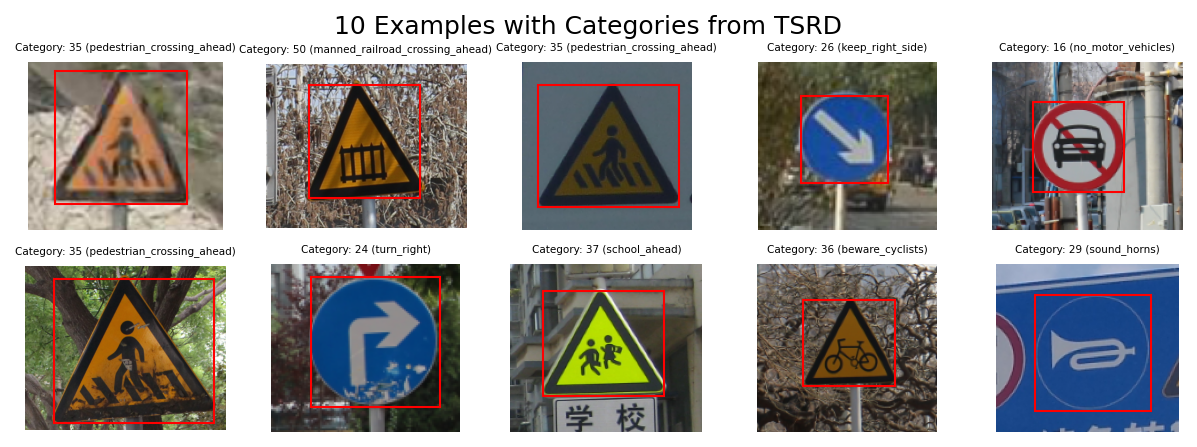

In [10]:
visualize_images(samples, draw_bounding_box=True)

Immediately, we notice that multiple images belonging to the same category can have very different resolutions and varying patches of dirt on them, as is to be expected from real-world images. That said, all the images are fairly distinct, and the classes (at least to a human) are separated *very* cleanly with little to no overlap (as one would expect from traffic signs!).

Now let's look at exactly one image from each categories to see what all the categories are:

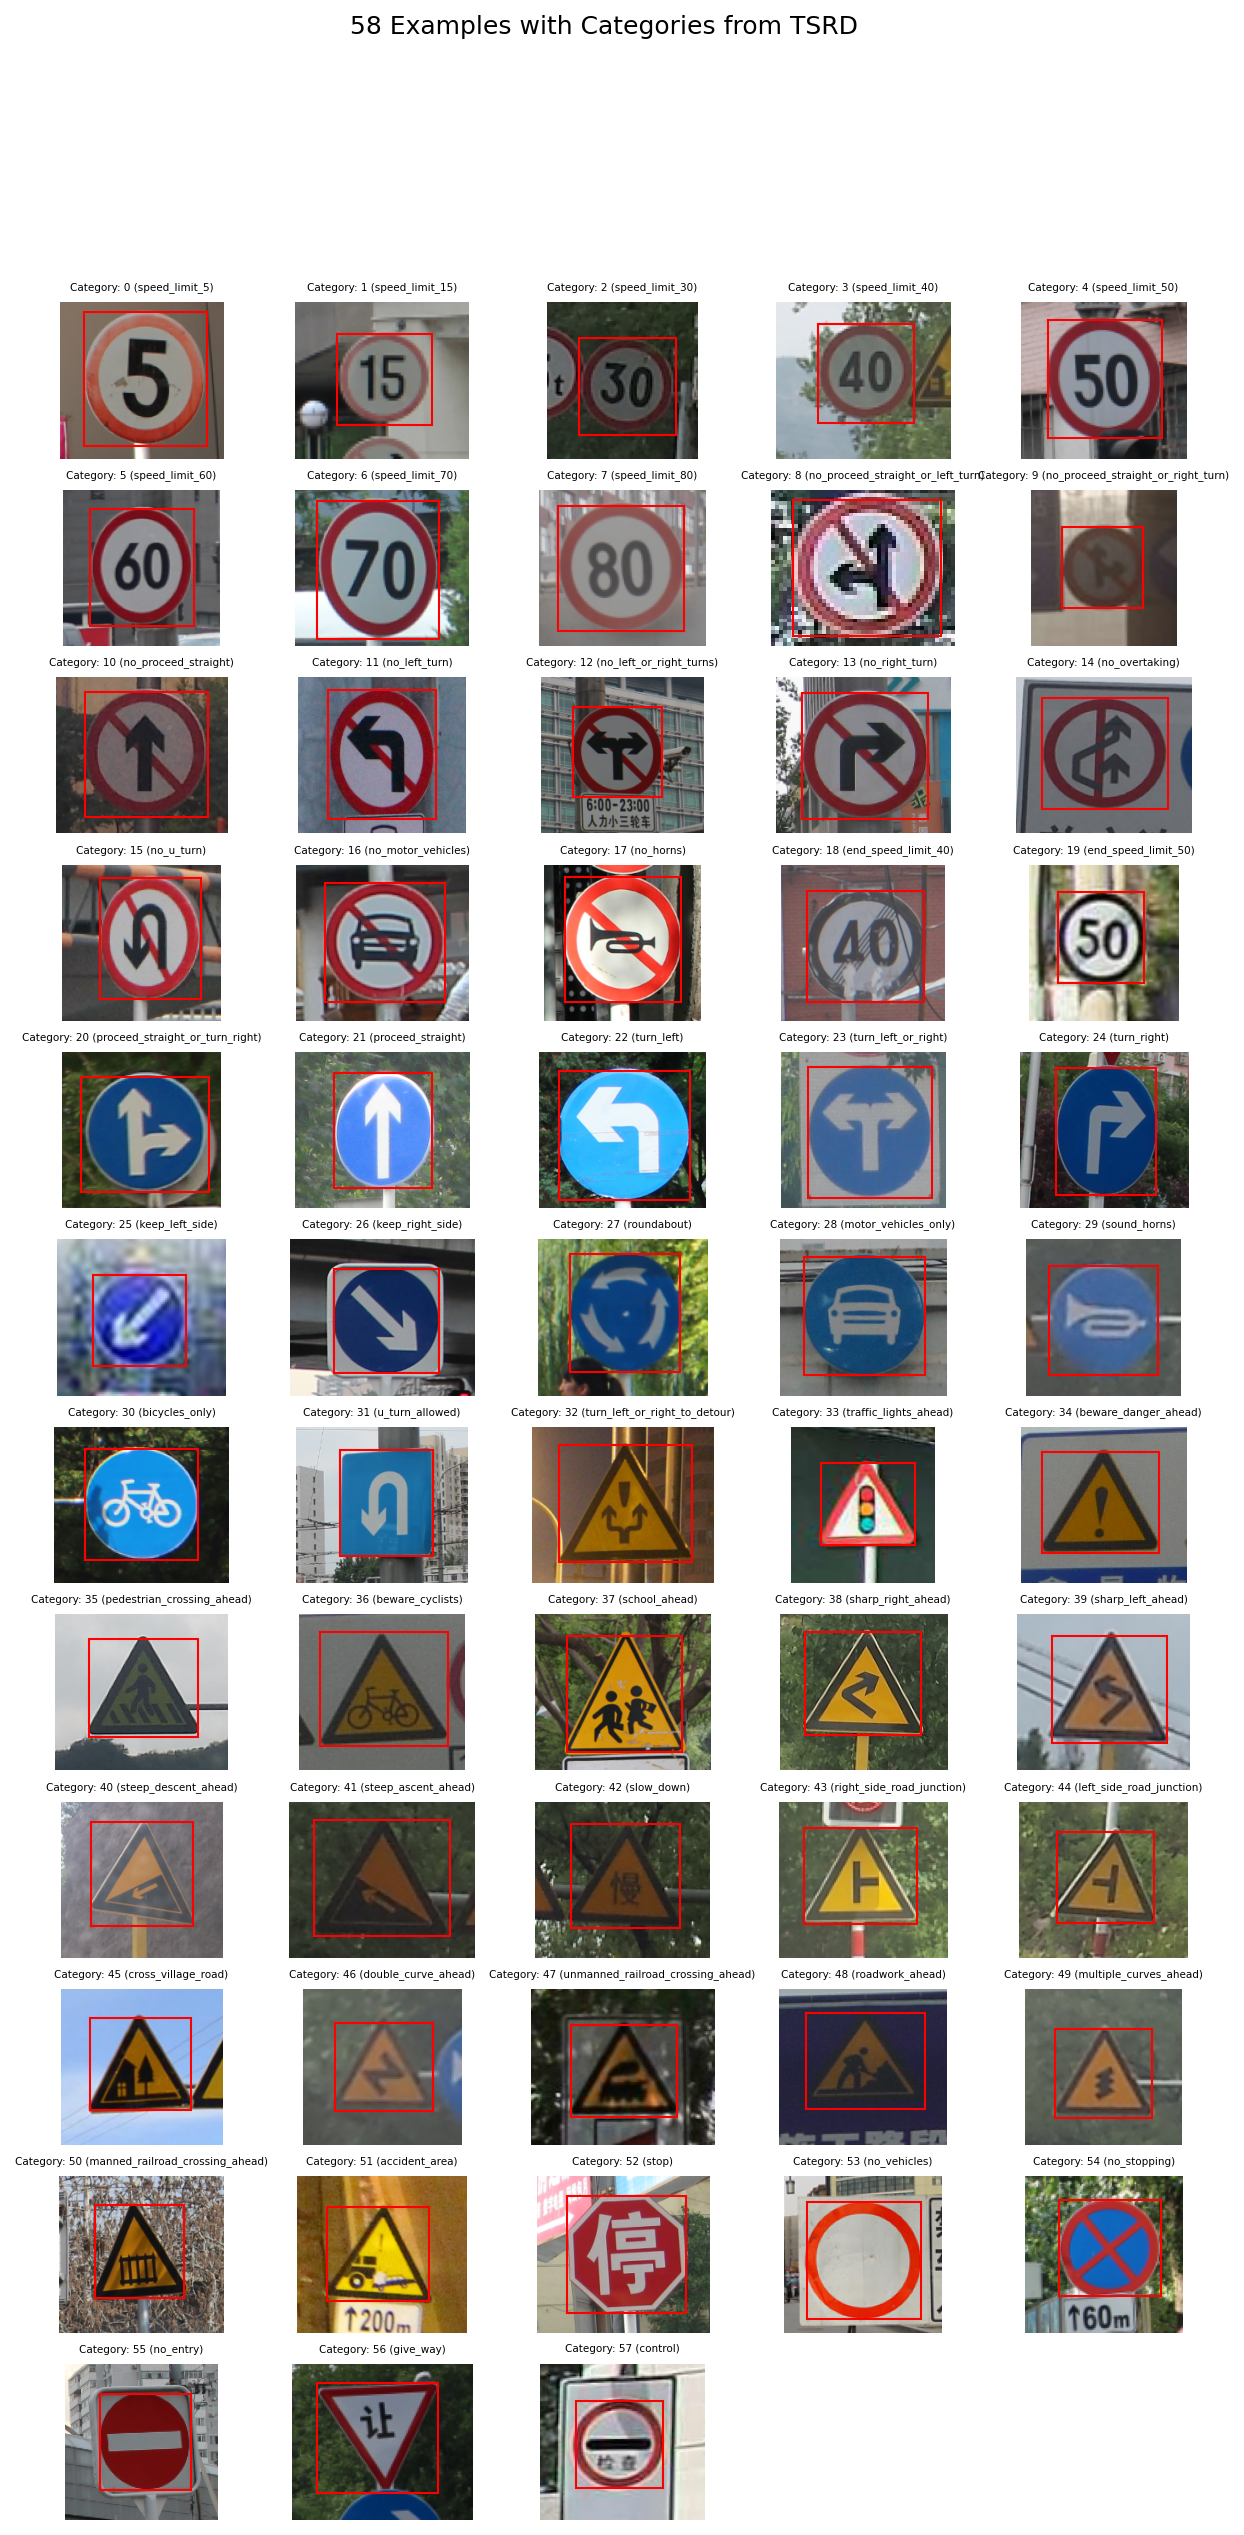

In [11]:
visualize_images(labels_all.groupby("Category").first().reset_index(), draw_bounding_box=True)

Note that all the images are relatively zoomed in. Furthermore, note that:
* There are 5 sign shapes:
    * Circular (most common).
    * Triangular (exclusively for warning signs).
    * Upside-down triangular (just the `give_way` signs).
    * Octogonal (just the `stop` sign).
    * Rectangular (occassional regulatory signs).
* There are 4 major color schemes:
    * Red and white (most prohibition signs).
    * Blue (most regulatory signs).
    * Black and yellow/orange (most warning signs).
    * Black and white (end restriction signs).

Again, the classes are separated pretty well -- no ambiguities!

# Analyzing the category distributions:

What does the category distribution look like across both the training and testing sets?

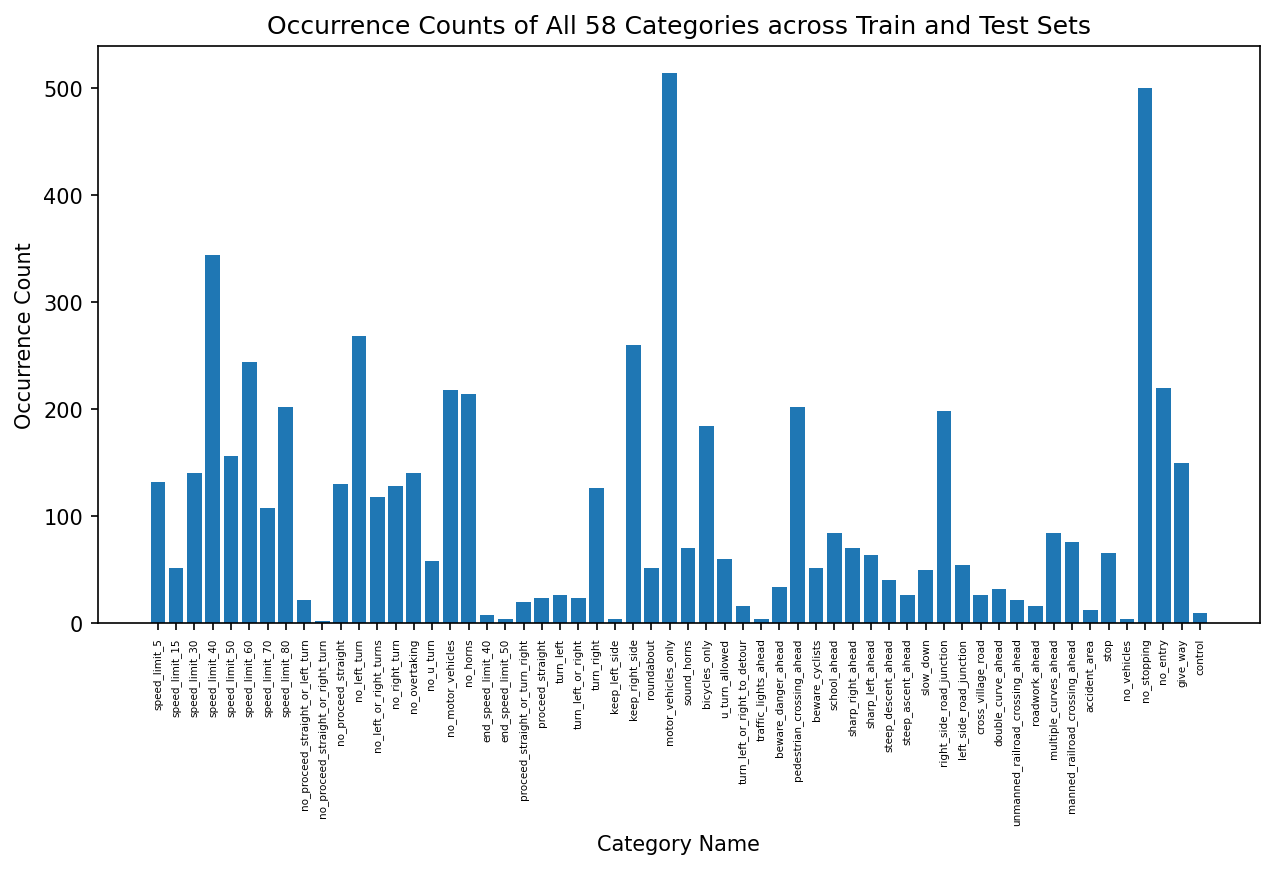

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
cats_gb = labels_all.groupby("Category")["CategoryName_English"]
counts = cats_gb.count()
labels = cats_gb.first()
ax.bar(x=counts.index, height=counts)
ax.set_title("Occurrence Counts of All 58 Categories across Train and Test Sets")
ax.set_xlabel("Category Name")
ax.set_ylabel("Occurrence Count")
ax.set_xticks(counts.index)
ax.set_xticklabels(labels, rotation=90, size=5)
plt.show()

As we can see, the distribution is very uneven. On the one hand, the category `no_proceed_straight_or_right_turn` only appears twice in the entire dataset (both being in the training set), whereas the category `motor_vehicles_only` appears a total of 514 times.

What does this same distribution look like between the train and test sets?

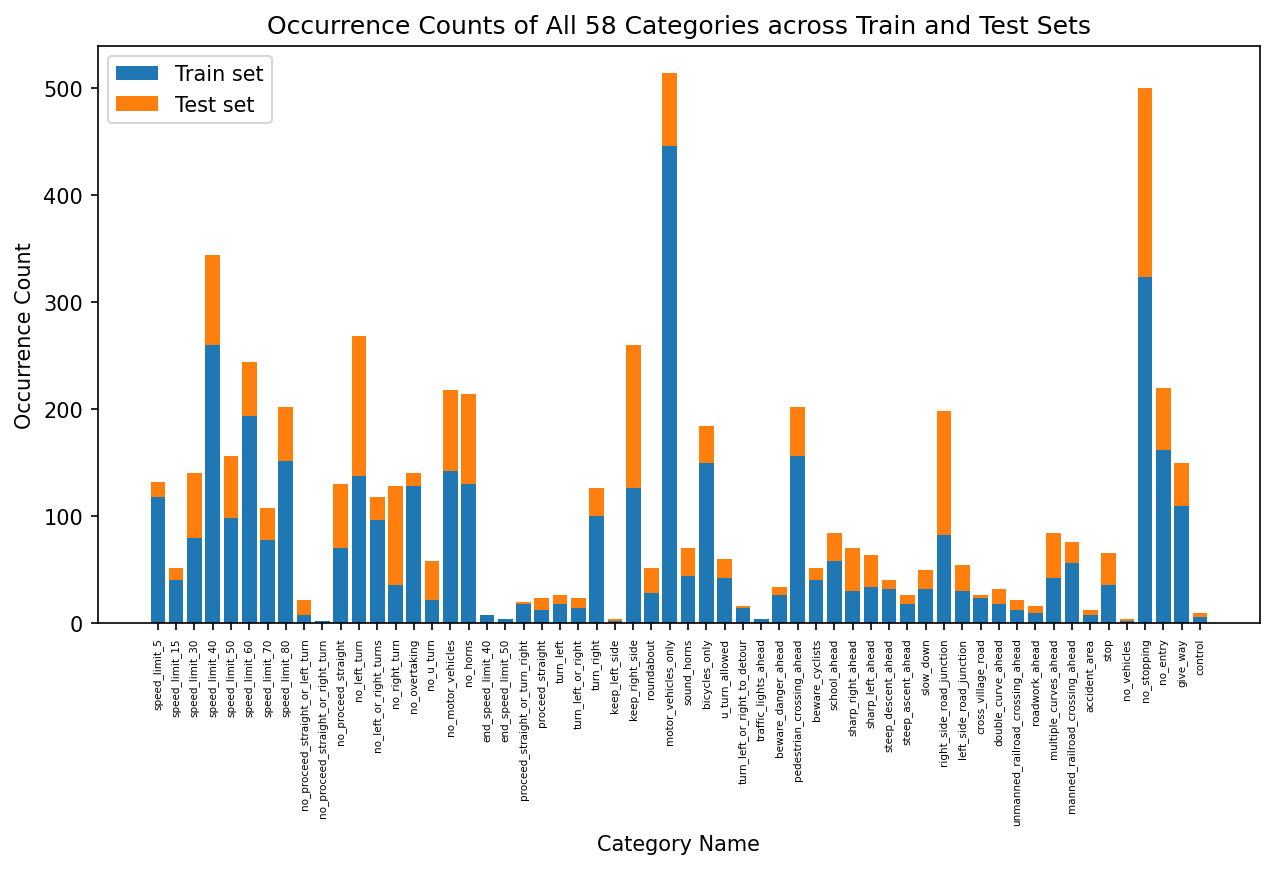

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
cats = pd.DataFrame(labels_all.groupby("Category")["CategoryName_English"].first()).reset_index()
cats = cats.merge(labels_all.query("IsTest==False").groupby("Category").IsTest.count().rename("TrainCounts").reset_index(),how="left")
cats = cats.merge(labels_all.query("IsTest==True").groupby("Category").IsTest.count().rename("TestCounts").reset_index(),how="left")
cats = cats.fillna(0)
ax.bar(x=cats.Category, height=cats.TrainCounts, label="Train set")
ax.bar(x=cats.Category, height=cats.TestCounts, label="Test set", bottom=cats.TrainCounts)
ax.set_title("Occurrence Counts of All 58 Categories across Train and Test Sets")
ax.set_xlabel("Category Name")
ax.set_ylabel("Occurrence Count")
ax.set_xticks(cats.Category)
ax.set_xticklabels(cats.CategoryName_English, rotation=90, size=5)
ax.legend()
plt.show()

The proportion of train occurrence to test ocurrence does indeed differ across categories, i.e. some categories are almost all in training and some are split almost evenly. Note that, again, there are several classes that are only in the train set. Luckily, there are no classes that are only in the test set!